In [344]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import requests
import numpy as np
import seaborn as sns
import matplotlib.pylab as pylab

params = {'legend.fontsize': '13',
          'figure.figsize': (20, 10),
         'axes.labelsize': '13',
         'axes.titlesize':'18',
         'xtick.labelsize':'13',
         'ytick.labelsize':'13'}
pylab.rcParams.update(pylab.rcParamsDefault)
pylab.rcParams.update(params)

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [156]:
df_tests = pd.read_csv('data/test.psv', sep = '|', encoding = 'unicode_escape')
df_vehicles = pd.read_csv('data/veh.psv', sep = '|', encoding = 'unicode_escape')
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')
df_matched_vehicles = pd.read_csv('matched_vehicles.csv', encoding = 'unicode_escape')
df_all_ratings = pd.read_csv('all_ratings.csv', encoding = 'unicode_escape')

/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [157]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)


# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'}
}
df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'}
}
df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'}
}


for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

In [158]:
car_accident_indicies = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')].Accident_Index.unique()
df_uk_vehicles = df_uk_vehicles[df_uk_vehicles.Accident_Index.isin(car_accident_indicies)]
df_uk_accidents = df_uk_accidents[df_uk_accidents.Accident_Index.isin(car_accident_indicies)]
df_uk_casualties = df_uk_casualties[df_uk_casualties.Accident_Index.isin(car_accident_indicies)]

In [159]:
# additional preprocessing for vehicles, ratings
df_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan}
}

for key in df_vehicles_map:
    for old_value in df_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])
        df_matched_vehicles[key] = df_matched_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])
        
df_all_ratings = df_all_ratings.replace('Not Rated', np.nan)

### Merging NCAP ratings for models with mutiple ratings per year

In [160]:
df_all_ratings[['OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'SIDE_POLE_STARS']] = df_all_ratings[['OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'SIDE_POLE_STARS']].astype(float)
df_ratings_merged = df_all_ratings.groupby(by=['MAKE', 'MODEL', 'MODEL_YR']).agg('mean').reset_index()

In [161]:
df_ratings_merged = df_ratings_merged.drop(df_ratings_merged[(df_ratings_merged['FRNT_DRIV_STARS'].isnull()) \
                                                             & (df_ratings_merged['FRNT_PASS_STARS'].isnull()) \
                                                             & (df_ratings_merged['OVERALL_SIDE_STARS'].isnull()) \
                                                             & (df_ratings_merged['OVERALL_STARS'].isnull()) \
                                                             & (df_ratings_merged['ROLLOVER_POSSIBILITY'].isnull()) \
                                                             & (df_ratings_merged['ROLLOVER_STARS'].isnull()) \
                                                             & (df_ratings_merged['SIDE_POLE_STARS'].isnull())].index, inplace=False)

## Better matching for ratings?

In [162]:
df_matched = pd.read_csv('matched_vehicles_v2.csv')

In [163]:
# df_uk_vehicles['Vehicle_Make'] = df_uk_vehicles['Vehicle_Make'].str.replace('MERCEDES', 'MERCEDES-BENZ')
# df_uk_vehicles['Vehicle_Make'] = df_uk_vehicles['Vehicle_Make'].str.replace('ROLLS ROYCE', 'ROLLS-ROYCE')
# df_ratings_merged['MODEL_YR'] = df_ratings_merged['MODEL_YR'].astype(float)
# df_uk_min = df_uk_vehicles.copy(deep=True)
# df_ratings_min = df_ratings_merged.copy(deep=True)

# df_ratings_min['proc_MODEL'] = (df_ratings_min['MODEL'].str
#                                    .replace(' ', '')
#                                    .replace('-', '')
#                                    .replace('.', '')
#                                    .replace('+', '')
#                                    .replace('_', '')).copy(deep=True)
# df_ratings_min = df_ratings_min[df_ratings_min['MODEL_YR'] <= 2016]

# df_uk_min['proc_MODEL'] = (df_uk_min['Vehicle_Model'].str
#                                    .replace(' ', '')
#                                    .replace('-', '')
#                                    .replace('.', '')
#                                    .replace('+', '')
#                                    .replace('_', ''))

# df_uk_min = df_uk_min[(df_uk_min['Vehicle_Make'].notnull())
#                            & (df_uk_min['proc_MODEL'].notnull())
#                            & (df_uk_min['Vehicle_Year'].notnull())]

In [164]:
# matched_vehicles = pd.DataFrame()
# for make, group in df_ratings_min.groupby('MAKE'):
#     if df_uk_min['Vehicle_Make'].str.contains(make).any() == False:
#         print(make, 'doesnt exits in UK')
#         continue
#     print (make)
#     for index, rating in group.iterrows():
#         cur_uk_entries = df_uk_min[(df_uk_min['Vehicle_Make'] == make)
#                                       & (df_uk_min['Vehicle_Year'] == rating['MODEL_YR'])
#                                       & (df_uk_min['proc_MODEL'].str.contains(rating['proc_MODEL']))].copy(deep=True)
#         if len(cur_uk_entries) < 1:
#             continue
#         cur_uk_entries['NCAP_Model_Name'] = rating['MODEL']
#         if len(matched_vehicles) < 1:
#             matched_vehicles = cur_uk_entries
#         else:
#             matched_vehicles = matched_vehicles.append(cur_uk_entries, ignore_index=True)
#         print (len(matched_vehicles))
# df_ratings_min = df_ratings_min.rename(columns={'MAKE':'Vehicle_Make', 'MODEL':'NCAP_Model_Name', 'MODEL_YR':'Vehicle_Year'}).copy(deep=True)
# df_ratings_min = df_ratings_min[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'ROLLOVER_POSSIBILITY_2', 'SIDE_POLE_STARS', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
# df_matched_ratings = df_matched.merge(df_ratings_min, how='left', on=['Vehicle_Make', 'NCAP_Model_Name', 'Vehicle_Year'])
# df_matched_ratings.ROLLOVER_POSSIBILITY = df_matched_ratings.ROLLOVER_POSSIBILITY.replace(0, np.nan)
# df_matched_ratings.ROLLOVER_POSSIBILITY_2 = df_matched_ratings.ROLLOVER_POSSIBILITY_2.replace(0, np.nan)
# df_matched_ratings.to_csv('matched_vehicles_v2.csv')

## Analysis

In [165]:
df_matched_ratings = pd.read_csv('matched_vehicles_v2.csv')
df_matched_ratings = df_matched_ratings.loc[:,~df_matched_ratings.columns.str.startswith('Unnamed')]
df_matched_ratings

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year,NCAP_Model_Name,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,VEHICLE_ID,proc_MODEL
0,200540B016730,3,Car,Slowing or stopping,0,1,1,0,0,0,Back,2,Female,46,46-55,1994.000,1,15.000,2,AUDI,100 AVANT E AUTO,1990.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,5.000,4.000,2.000,2872.000,100
1,2007440586334,2,Car,Going ahead left-hand bend,0,0,0,0,0,0,Front,15,Female,39,36-45,2309.000,1,17.000,1,AUDI,100 AVANT E AUTO,1990.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,5.000,4.000,2.000,2872.000,100
2,200501FH10500,1,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,57,56-65,2309.000,1,14.000,1,AUDI,100E AUTO,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
3,200501FH10578,2,Car,Going ahead right-hand bend,0,8,0,0,1,0,Front,15,Male,50,46-55,2309.000,1,14.000,-1,AUDI,100E AUTO,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
4,200501WW50741,1,Car,Turning right,0,8,0,0,0,0,Front,2,Male,18,16-20,2771.000,1,14.000,1,AUDI,100E AUTO,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
5,200501YR99026,1,Car,Turning right,0,8,0,0,0,0,Offside,15,Female,63,56-65,2771.000,1,14.000,1,AUDI,100E AUTO,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
6,2009330902716,1,Car,Turning right,0,6,0,0,0,0,Front,15,Male,68,66-75,1984.000,1,18.000,2,AUDI,100E,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
7,2009470900680,1,Car,Reversing,0,0,0,0,0,0,Back,15,Male,42,36-45,1984.000,1,18.000,2,AUDI,100E,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
8,200950JN2L011,1,Car,Waiting to go - held up,0,0,0,0,0,0,Back,15,Male,30,26-35,2309.000,1,18.000,-1,AUDI,100E,1991.000,100,nan,5.000,4.000,nan,nan,nan,nan,nan,nan,nan,nan,10.000,4.000,1.000,2954.000,100
9,2016010000433,3,Car,Overtaking moving vehicle – offside,0,1,0,0,0,0,Front,6,NaN,-1,NaN,1896.000,2,10.000,-1,AUDI,A3 TDI,2006.000,A3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,102.000,3.000,0.000,1875.000,A3


In [166]:
df_vehicles_casualties = df_uk_casualties.merge(df_matched_ratings, on = ['Accident_Index', 'Vehicle_Reference'], how='inner')

In [167]:
df_vehicles_casualties

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year,NCAP_Model_Name,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,VEHICLE_ID,proc_MODEL
0,2016010000008,1,1,Driver or rider,Male,24,5,Slight,0,0,0,0,0,9,Car,Going ahead other,0,4,5,0,0,0,Front,6,Male,24,21-25,1390.000,1,5.000,1,VOLKSWAGEN,SCIROCCO TSI,2011.000,CC,nan,nan,nan,nan,nan,nan,4.000,nan,nan,nan,nan,65.000,4.000,2.000,553.500,CC
1,2016010000021,2,1,Driver or rider,Female,30,6,Slight,0,0,0,0,0,9,Car,Going ahead other,0,2,0,0,0,0,Nearside,6,Female,30,26-35,1596.000,1,15.000,1,FORD,FOCUS BLACK,2001.000,FOCUS,nan,4.500,4.500,nan,3.500,2.500,nan,nan,nan,nan,nan,1777.000,14.000,9.000,4363.500,FOCUS
2,2016010000048,1,1,Pedestrian,Male,62,9,Serious,1,1,0,0,2,0,Car,Turning right,0,8,0,11,0,0,Nearside,1,Male,59,56-65,1399.000,2,5.000,1,FORD,FIESTA EDGE TDCI 70,2011.000,EDGE,4.000,3.000,3.000,5.000,5.000,5.000,4.000,0.150,nan,nan,5.000,1274.000,3.000,1.000,321.000,EDGE
3,2016010000048,1,1,Pedestrian,Male,62,9,Serious,1,1,0,0,2,0,Car,Turning right,0,8,0,11,0,0,Nearside,1,Male,59,56-65,1399.000,2,5.000,1,FORD,FIESTA EDGE TDCI 70,2011.000,FIESTA,4.000,5.000,4.000,5.000,4.000,5.000,4.000,0.143,nan,nan,4.000,528.000,2.000,2.000,160.500,FIESTA
4,2016010000051,2,2,Driver or rider,Male,37,7,Slight,0,0,0,0,0,9,Car,Going ahead other,0,1,0,0,0,0,Front,6,Male,37,36-45,1796.000,1,14.000,1,FORD,FOCUS ZETEC,2002.000,FOCUS,nan,4.667,4.000,nan,3.500,2.500,nan,nan,nan,nan,nan,990.667,9.000,5.000,4529.000,FOCUS
5,2016010000051,2,3,Passenger,Female,61,9,Slight,0,0,1,0,0,9,Car,Going ahead other,0,1,0,0,0,0,Front,6,Male,37,36-45,1796.000,1,14.000,1,FORD,FOCUS ZETEC,2002.000,FOCUS,nan,4.667,4.000,nan,3.500,2.500,nan,nan,nan,nan,nan,990.667,9.000,5.000,4529.000,FOCUS
6,2016010000055,1,1,Driver or rider,Male,77,11,Slight,0,0,0,0,0,9,Car,Waiting to turn left,0,0,0,0,1,0,Offside,6,Male,77,Over 75,1598.000,1,10.000,1,TOYOTA,COROLLA TSPIRIT VVTI,2006.000,COROLLA,nan,5.000,5.000,nan,4.000,4.000,nan,nan,0.127,nan,nan,829.000,9.000,3.000,1791.000,COROLLA
7,2016010000061,1,1,Pedestrian,Female,2,1,Slight,9,9,0,0,2,0,Car,Going ahead other,0,0,0,0,0,0,Front,2,Female,48,46-55,1242.000,1,5.000,1,FORD,FIESTA EDGE,2011.000,EDGE,4.000,3.000,3.000,5.000,5.000,5.000,4.000,0.150,nan,nan,5.000,1274.000,3.000,1.000,321.000,EDGE
8,2016010000061,1,1,Pedestrian,Female,2,1,Slight,9,9,0,0,2,0,Car,Going ahead other,0,0,0,0,0,0,Front,2,Female,48,46-55,1242.000,1,5.000,1,FORD,FIESTA EDGE,2011.000,FIESTA,4.000,5.000,4.000,5.000,4.000,5.000,4.000,0.143,nan,nan,4.000,528.000,2.000,2.000,160.500,FIESTA
9,2016010000081,1,1,Driver or rider,Male,32,6,Slight,0,0,0,0,0,9,Car,Changing lane to left,0,0,5,0,0,0,Front,2,Male,32,26-35,998.000,1,1.000,1,FORD,FIESTA ZETEC,2015.000,FIESTA,4.000,5.000,4.000,2.000,4.000,2.000,4.000,0.143,nan,nan,5.000,61.000,2.000,0.000,9258.500,FIESTA


In [168]:
df_casualty_cars = df_vehicles_casualties[(df_vehicles_casualties.Casualty_Severity == 'Serious') | (df_vehicles_casualties.Casualty_Severity == 'Fatal')]
#df_casualty_cars = df_casualty_cars[['Vehicle_Make', 'NCAP_Model_Name', 'Vehicle_Year', 'Casualty_Severity']]

accidents_per_car = df_matched_ratings[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Index']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
accidents_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Count']

In [169]:
casualties_per_car = df_casualty_cars[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Casualty_Severity']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
casualties_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Severe_Casualty_Count']

In [170]:
df_severe_matched = pd.merge(accidents_per_car, casualties_per_car, on=['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'])
df_severe_matched['Severe_Casualties_Per_Accident'] = df_severe_matched.Severe_Casualty_Count * 100 / df_severe_matched.Accident_Count
df_severe_matched = df_severe_matched.sort_values(by='Accident_Count', ascending = False)

In [171]:
df_uk_vehicles[(df_uk_vehicles.Vehicle_Model.notnull()) & (df_uk_vehicles.Vehicle_Make.str.contains('AUDI')) & (df_uk_vehicles.Vehicle_Model.str.contains('100'))].head(100)

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year
248426,2016010018016,1,Car,Moving off,0,8,0,0,0,0,Offside,6,Male,69,66-75,1984.000,1,24.000,1,AUDI,100E,1992.000
290205,201604WA16133,1,Car,Going ahead other,0,8,0,0,0,0,Front,6,Male,22,21-25,1968.000,2,8.000,1,AUDI,100 AVANT TD,2008.000
313904,2016120023493,1,Car,Turning right,0,0,0,0,0,0,Offside,2,Female,32,26-35,1968.000,2,8.000,1,AUDI,100 GL 5E AUTO,2008.000
318592,20161332I1532,1,Car,Turning right,0,8,0,0,0,0,Front,6,Male,23,21-25,1968.000,2,8.000,1,AUDI,100 AVANT TD,2008.000
423191,2016450043432,1,Car,Going ahead other,0,0,1,0,0,0,Front,5,Male,38,36-45,1984.000,1,24.000,1,AUDI,100E,1992.000
595358,2015200038740,2,Car,Going ahead other,0,0,0,0,0,0,Front,6,Male,71,66-75,2771.000,1,22.000,3,AUDI,100E QUATTRO AUTO,nan
736063,2015921500975,1,Car,Going ahead other,0,0,0,0,0,0,Front,6,Male,22,21-25,1984.000,1,7.000,1,AUDI,100 GL,nan
756834,200501FH10500,1,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,57,56-65,2309.000,1,14.000,1,AUDI,100E AUTO,1991.000
756945,200501FH10578,2,Car,Going ahead right-hand bend,0,8,0,0,1,0,Front,15,Male,50,46-55,2309.000,1,14.000,-1,AUDI,100E AUTO,1991.000
774692,200501QK50072,1,Car,Moving off,0,1,0,0,0,0,Front,15,Female,65,56-65,2226.000,1,17.000,1,AUDI,100 AVANT QUATTRO,1988.000


In [172]:
df_ncap_uk = df_severe_matched.merge(df_matched_ratings, on = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'], how = 'left')
#df_ncap_uk['AVERAGE_STARS'] = df_ncap_uk.OVERALL_STARS

In [318]:
df_ncap_uk_part = df_ncap_uk.copy(deep=True)

In [319]:
df_ncap_uk_n = df_ncap_uk_part.copy(deep=True)#[['Vehicle_Make', 'NCAP_Model_Name', 'Vehicle_Year', 'OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']].copy(deep=True)
#df_ncap_uk[['OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']] = df_ratings_proc[['OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']].astype(float)
display(df_ncap_uk_n.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194496 entries, 0 to 194495
Data columns (total 42 columns):
Vehicle_Make                        194496 non-null object
Vehicle_Model                       194496 non-null object
Vehicle_Year                        194496 non-null float64
Accident_Count                      194496 non-null int64
Severe_Casualty_Count               194496 non-null int64
Severe_Casualties_Per_Accident      194496 non-null float64
Accident_Index                      194496 non-null object
Vehicle_Reference                   194496 non-null int64
Vehicle_Type                        194491 non-null object
Vehicle_Manoeuvre                   194405 non-null object
Vehicle_Location-Restricted_Lane    194496 non-null int64
Junction_Location                   194496 non-null int64
Skidding_and_Overturning            194496 non-null int64
Hit_Object_in_Carriageway           194496 non-null int64
Vehicle_Leaving_Carriageway         194496 non-null int64
Hit_Object

None

In [320]:
df_years_grouped = df_ncap_uk_n.groupby('Vehicle_Year')
normalized_cols = ['OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS']
for year, group in df_years_grouped:
    for col in normalized_cols:
        df_ncap_uk_n.loc[df_ncap_uk_n['Vehicle_Year'] == year, col] = (df_ncap_uk_n[df_ncap_uk_n.Vehicle_Year == year][col]-df_ncap_uk_n[df_ncap_uk_n.Vehicle_Year == year][col].min())/(df_ncap_uk_n[df_ncap_uk_n.Vehicle_Year == year][col].max()-df_ncap_uk_n[df_ncap_uk_n.Vehicle_Year == year][col].min()) * 5

In [359]:
df_ncap_uk_part = df_ncap_uk_n.copy(deep=True)


(7.0, 0.0)

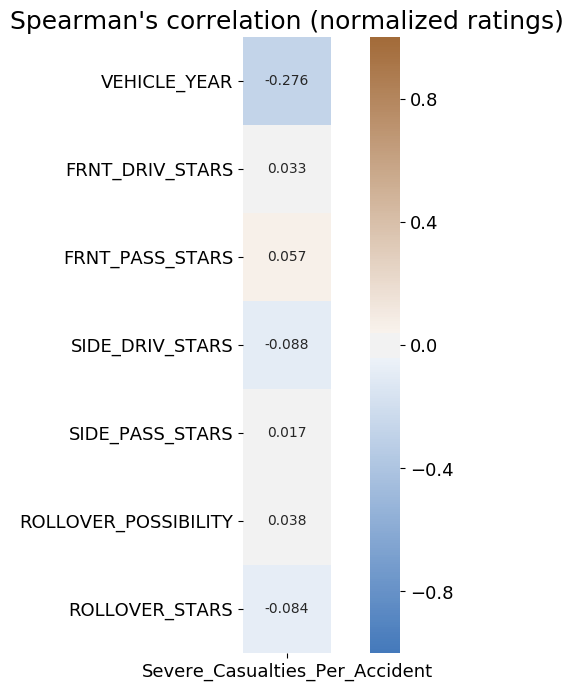

In [360]:
data = df_ncap_uk_part[df_ncap_uk_part.Accident_Count >50][['Vehicle_Year', 'Severe_Casualties_Per_Accident', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_POSSIBILITY', 'ROLLOVER_STARS']]
data = data.rename(columns={'Vehicle_Year':'VEHICLE_YEAR'})
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method='spearman')['Severe_Casualties_Per_Accident'].to_frame()
corr = corr.drop(['Severe_Casualties_Per_Accident'])
plot = sns.heatmap(corr, cmap=sns.diverging_palette(250, 40, as_cmap=True),
            square=True, annot=True,fmt='.3f', vmin=-1, vmax=1, ax=ax)
plot.set_title('Spearman\'s correlation (normalized ratings)')
bottom, top = plot.get_ylim()
plt.yticks(rotation=0)
plot.set_ylim(bottom + 0.5, top - 0.5)


In [312]:
df_ncap_uk_grouped = df_ncap_uk_part[(df_ncap_uk_part.Accident_Count >= 50)].drop(columns=['Severe_Casualty_Count', 'Accident_Count'])
df_ncap_uk_grouped = df_ncap_uk_grouped.groupby(['Vehicle_Make', 'Vehicle_Model']).agg('mean').reset_index()

In [313]:
df_ncap_uk_grouped = df_ncap_uk_grouped.sort_values(by='Severe_Casualties_Per_Accident')
data = df_ncap_uk_grouped.drop(columns=['Vehicle_Make', 'Vehicle_Year', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT'])

In [314]:
params = {'legend.fontsize': '17',
          'figure.figsize': (15, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'25',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
pylab.rcParams.update(pylab.rcParamsDefault)
pylab.rcParams.update(params)

Text(0.5, 1.0, 'Severe casualties vs NCAP front driver rating')

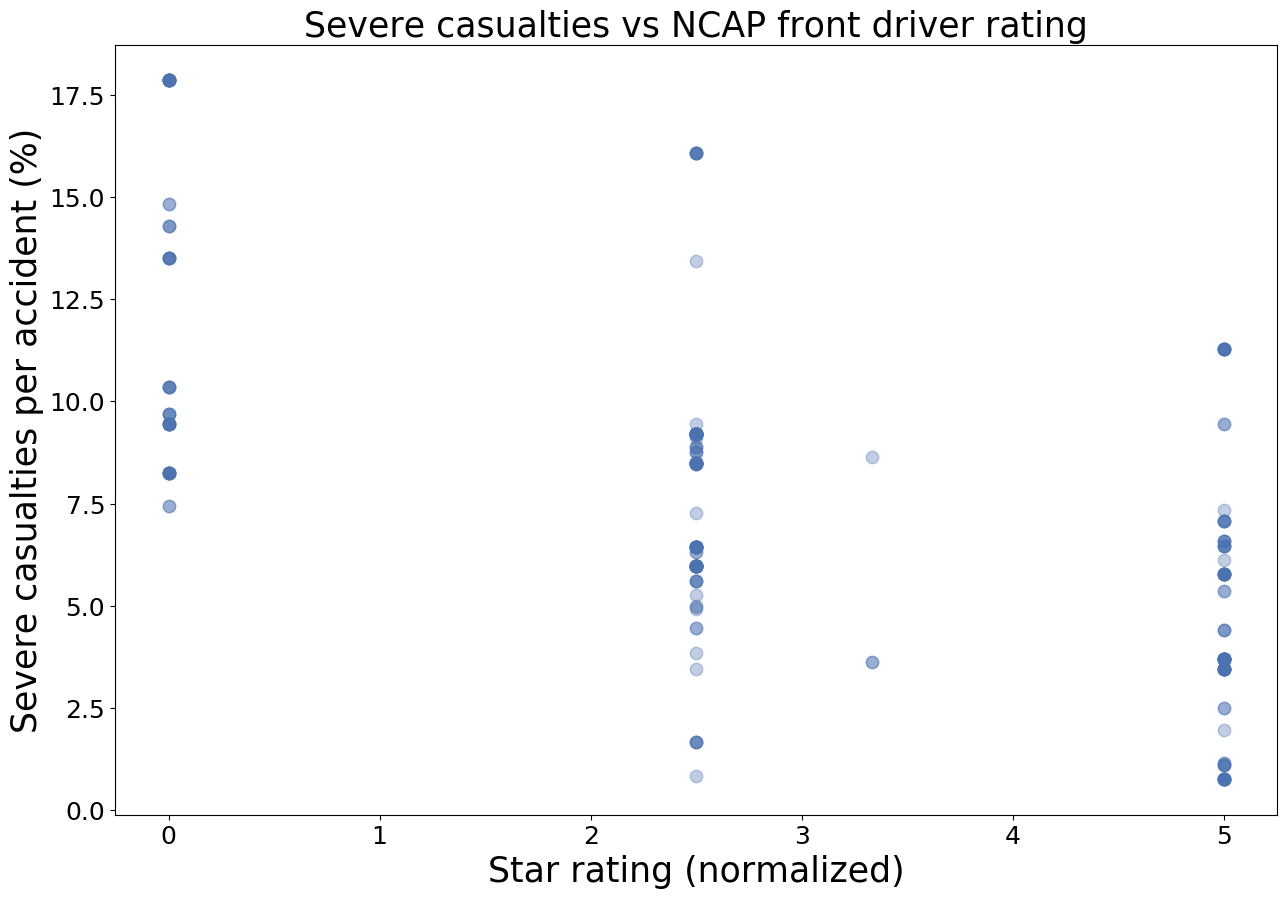

In [317]:
#ax = df_ncap_uk_n[df_ncap_uk_n.Accident_Count > 50].plot(legend = False, kind="scatter", x="ROLLOVER_POSSIBILITY",y="Severe_Casualties_Per_Accident", color="b", s=80, alpha=0.35)
ax = df_ncap_uk_part[df_ncap_uk_part.Accident_Count > 50].plot(legend = False, kind="scatter", x="FRNT_DRIV_STARS",y="Severe_Casualties_Per_Accident", color="b", s=80, alpha=0.35)
ax.set_ylabel("Severe casualties per accident (%)")
ax.set_xlabel("Star rating (normalized)")
ax.set_title('Severe casualties vs NCAP front driver rating')

Text(0.5, 1.0, 'Severe casualties vs NCAP rollover possibility')

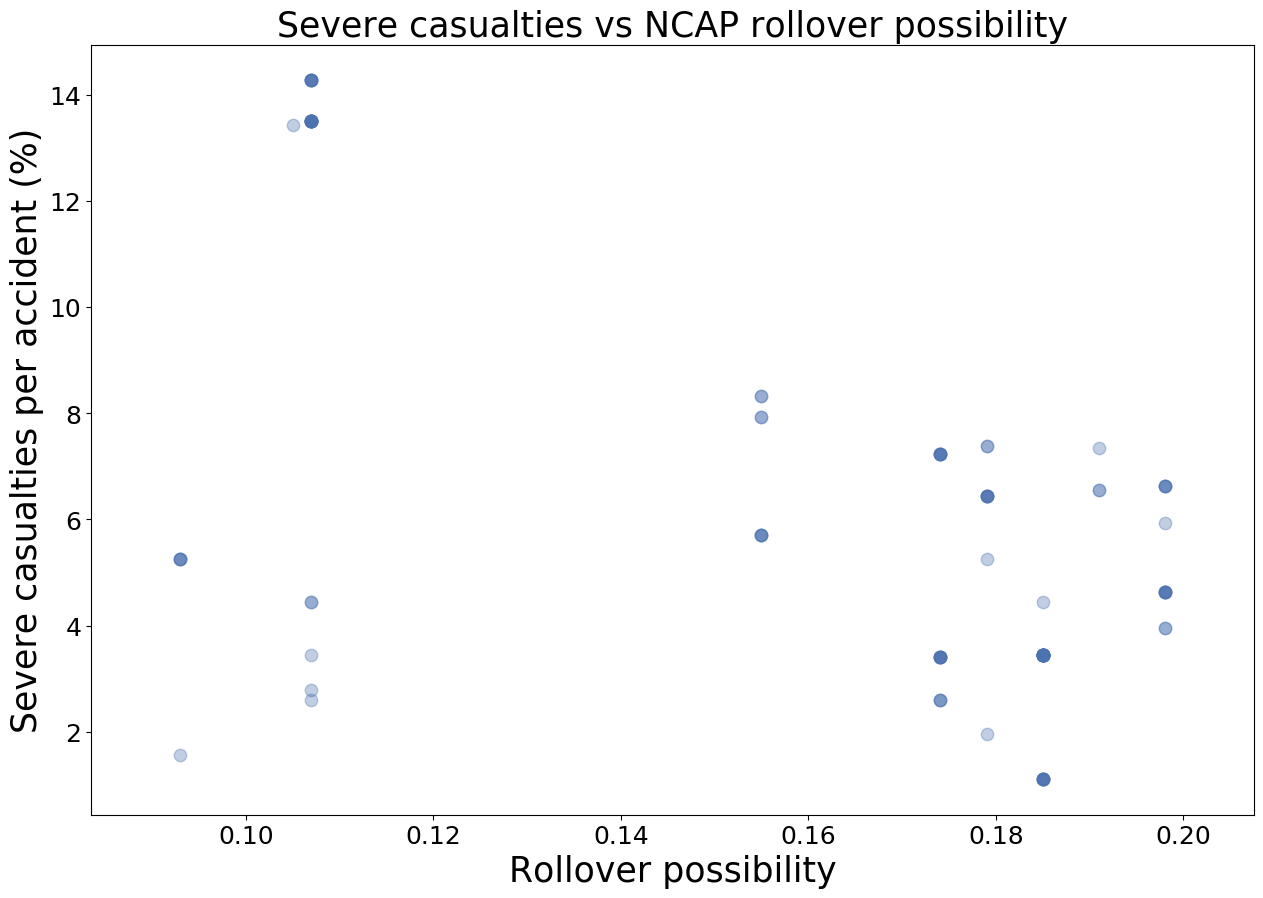

In [286]:
ax = df_ncap_uk_n[df_ncap_uk_n.Accident_Count > 50].plot(legend = False, kind="scatter", x="ROLLOVER_POSSIBILITY",y="Severe_Casualties_Per_Accident", color="b", s=80, alpha=0.35)
ax.set_ylabel("Severe casualties per accident (%)")
ax.set_xlabel("Rollover possibility")
ax.set_title('Severe casualties vs NCAP rollover possibility')

# for i, row in df_ncap_uk_n[df_ncap_uk_n.Accident_Count > 50].iterrows():
#     ax.annotate(row['Vehicle_Model'], (row['ROLLOVER_POSSIBILITY'], row['Severe_Casualties_Per_Accident']))

In [247]:
df_ncap_uk_n[df_ncap_uk_n.Accident_Count > 50]

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,NCAP_Model_Name,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,VEHICLE_ID,proc_MODEL
19415,AUDI,A4 TDI SPORT,2004.000,270,12,4.444,2009160B01940,1,Car,Going ahead other,0,0,0,0,0,0,Front,15,Female,25,21-25,2496.000,2,5.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,0.000,0.107,nan,nan,nan,178.000,3.000,1.000,1014.000,A4
19535,AUDI,A4 TDI SPORT,2004.000,270,12,4.444,2014170L20904,1,Car,Going ahead other,0,4,0,0,0,0,Front,2,Male,22,21-25,2496.000,2,10.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,0.000,0.107,nan,nan,nan,178.000,3.000,1.000,1014.000,A4
24332,AUDI,A4 TDI SE,2002.000,240,12,5.000,201443R208084,1,Car,Slowing or stopping,0,0,0,0,0,0,Front,6,Female,24,21-25,2496.000,2,12.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,5.000,nan,nan,nan,nan,184.000,1.000,0.000,4664.000,A4
24357,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2005620140707,2,Car,Going ahead right-hand bend,0,0,1,0,1,4,Front,15,Male,25,21-25,2616.000,1,1.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24370,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,20063102C3676,1,Car,Going ahead other,0,0,1,0,1,4,Front,15,Male,21,21-25,2616.000,1,2.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24379,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2006556E04374,2,Car,Going ahead other,0,8,0,0,1,10,Front,1,Female,22,21-25,2616.000,1,2.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24393,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200720F204401,1,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,21,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24411,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2007950004568,2,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,22,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24412,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200797AB02406,1,Car,Overtaking static vehicle - offside,0,2,0,0,0,0,Front,2,Male,25,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24414,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200801KD75259,3,Car,Going ahead other,0,0,0,11,0,0,Front,15,Male,25,21-25,2616.000,1,4.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8


In [245]:
df_ncap_uk_n

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,NCAP_Model_Name,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,VEHICLE_ID,proc_MODEL
19415,AUDI,A4 TDI SPORT,2004.000,270,12,4.444,2009160B01940,1,Car,Going ahead other,0,0,0,0,0,0,Front,15,Female,25,21-25,2496.000,2,5.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,0.000,0.107,nan,nan,nan,178.000,3.000,1.000,1014.000,A4
19535,AUDI,A4 TDI SPORT,2004.000,270,12,4.444,2014170L20904,1,Car,Going ahead other,0,4,0,0,0,0,Front,2,Male,22,21-25,2496.000,2,10.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,0.000,0.107,nan,nan,nan,178.000,3.000,1.000,1014.000,A4
24332,AUDI,A4 TDI SE,2002.000,240,12,5.000,201443R208084,1,Car,Slowing or stopping,0,0,0,0,0,0,Front,6,Female,24,21-25,2496.000,2,12.000,1,A4,nan,2.500,2.500,nan,5.000,0.000,5.000,nan,nan,nan,nan,184.000,1.000,0.000,4664.000,A4
24357,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2005620140707,2,Car,Going ahead right-hand bend,0,0,1,0,1,4,Front,15,Male,25,21-25,2616.000,1,1.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24370,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,20063102C3676,1,Car,Going ahead other,0,0,1,0,1,4,Front,15,Male,21,21-25,2616.000,1,2.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24379,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2006556E04374,2,Car,Going ahead other,0,8,0,0,1,10,Front,1,Female,22,21-25,2616.000,1,2.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24393,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200720F204401,1,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,21,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24411,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,2007950004568,2,Car,Going ahead other,0,8,0,0,0,0,Front,15,Male,22,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24412,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200797AB02406,1,Car,Overtaking static vehicle - offside,0,2,0,0,0,0,Front,2,Male,25,21-25,2616.000,1,3.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8
24414,MAZDA,RX-8 231 PS,2004.000,239,22,9.205,200801KD75259,3,Car,Going ahead other,0,0,0,11,0,0,Front,15,Male,25,21-25,2616.000,1,4.000,1,RX-8,nan,2.500,5.000,nan,2.500,0.000,nan,nan,nan,nan,nan,476.000,13.000,3.000,1322.000,RX-8


In [ ]:
minimized_ratings_copy = minimized_ratings.copy(deep=False)
minimized_ratings_copy = minimized_ratings_copy.rename(columns={'MAKE': 'Vehicle_Make', 'MODEL': 'Vehicle_Model', 'MODEL_YR': 'Vehicle_Year'})
df_ncap_uk = df_severe_matched.merge(minimized_ratings_copy, on = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'], how = 'left')
df_ncap_uk[df_ncap_uk.Accident_Count> 80]

In [ ]:
data = df_ncap_uk[df_ncap_uk.Accident_Count > 80].drop(columns=['Vehicle_Make', 'Vehicle_Model', 'Severe_Casualty_Count', 'Accident_Count'])
data = data.rename(columns={'Vehicle_Year': 'VEHICLE_YEAR', 'Severe_Casualties_Per_Accident': '%_Severe_Casualties'})
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method='spearman')['%_Severe_Casualties'].to_frame()
corr = corr.drop(['%_Severe_Casualties'])
plot = sns.heatmap(corr, cmap=sns.diverging_palette(250, 40, as_cmap=True),
            square=True, annot=True,fmt='.3f', vmin=-1, vmax=1, ax=ax)
plot.set_title('Spearman\'s correlation (normalized ratings)')
bottom, top = plot.get_ylim()
plot.set_ylim(bottom + 0.5, top - 0.5)


In [237]:
print('UK cars invloved in accidents: ', len(df_matched))
print('UK unique model/year combinations: ', len(df_matched.drop_duplicates(subset=['Vehicle_Model', 'Vehicle_Year'])))

UK cars invloved in accidents:  245571
UK unique model/year combinations:  15308


In [236]:
len(df_uk_vehicles.drop_duplicates(subset=['Vehicle_Model', 'Vehicle_Year']))

108668